In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations
import pickle
from copy import deepcopy

# disable warnings to ignore overflow error
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
# parameters for CSTR
T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4

t_final = 0.005
t_step = 1e-4
num_step = 10
num_dims = 4

# parameters for Reptile
seed = 0
plot = True
rng = np.random.RandomState(seed)
innerstepsize = 0.02 # stepsize in inner SGD for reptile
innerepochs = 1 # number of epochs of each inner SGD
outerstepsize0 = 0.1 # stepsize of outer optimization, i.e., meta-optimization
niterations = 1000 # number of outer updates; each iteration we sample one task and update on it
epochs = 1 # number of epochs
ntrain = 32 # size of training minibatches (K)
eval_step = 50 # evaluation step
threshold = 10 # threshold to check data correctness

In [ ]:
def generate_new(x):
    return x + x * np.random.uniform(-10, 10)

def generate_new_small(x):
    return x + x * np.random.uniform(-0.05, 0.05)

def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial
    T = T_initial

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if i % 5 == 0:
            C_A_list.append(C_A)
            T_list.append(T)

    return C_A_list, T_list

def to_tensor(x):
    return tf.convert_to_tensor(x, dtype=tf.float32)

def train_on_batch(x, y, model, optimizer):
    x = to_tensor(x)
    y = to_tensor(y)

    with tf.GradientTape() as tape:
        YHat = model(x)
        loss = mse_loss_fn(y, YHat)
        grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

def predict(x, model):
    x = to_tensor(x)
    return model(x).numpy()

def compute_loss(x, y, model):
    return np.square(predict(x, model) - y).mean()

In [ ]:
def gen_task(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step):
    isCorrect = False
    while isCorrect == False:
        T_0_new = generate_new(T_0)
        V_new = generate_new(V)
        F_new = generate_new(F)
        C_A0s_new = generate_new(C_A0s)
        Q_s_new = generate_new(Q_s)
        rho_L_new = generate_new_small(rho_L)
        C_p_new = generate_new_small(C_p)
        k_0_new = generate_new_small(k_0)
        E_new = generate_new_small(E)
        delta_H_new = generate_new_small(delta_H)

        # generating inputs and initial states for CSTR, all expressed in deviation form
        u1_list = np.linspace(-3.5, 3.5, 4, endpoint=True)
        u2_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
        T_initial = np.linspace(300, 600, 20, endpoint=True)
        CA_initial = np.linspace(0, 6, 20, endpoint=True)

        # restruture the data
        T_start = list()
        CA_start = list()

        for T in T_initial:
            for CA in CA_initial:
                CA_start.append(CA)
                T_start.append(T)

        CA_start = np.array([CA_start])
        T_start = np.array([T_start])
        x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)

        # get X and y data for training and testing
        CA_output = list()
        T_output = list()
        CA_input = list()
        T_input = list()
        CA0_input = list()
        Q_input = list()

        for u1 in u1_list:
            C_A0 = u1 + C_A0s_new
            for u2 in u2_list:
                Q = u2 + Q_s_new
                for C_A_initial, T_initial in x_deviation:

                    C_A_list, T_list = CSTR_simulation(F_new, V_new, C_A0, k_0_new, E_new, R, T_0_new, delta_H_new, rho_L_new, C_p_new, Q, t_final, t_step, C_A_initial, T_initial)
                    if np.isnan(C_A_list).any() == False and np.isnan(T_list).any() == False and np.isinf(C_A_list).any() == False and np.isinf(T_list).any() == False:
                        CA0_input.append(u1)
                        Q_input.append(u2)
                        CA_input.append(C_A_initial)
                        T_input.append(T_initial)

                        CA_output.append(C_A_list)
                        T_output.append(T_list)

        # regenerate data if requirement is not met
        if len(CA_output) > ntrain:

            # collate input for RNN
            CA0_input = np.array(CA0_input)
            CA0_input = CA0_input.reshape(-1,1,1)

            Q_input = np.array(Q_input)
            Q_input = Q_input.reshape(-1,1,1)

            CA_input = np.array(CA_input)
            CA_input = CA_input.reshape(-1,1,1)

            T_input = np.array(T_input)
            T_input = T_input.reshape(-1,1,1)

            RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input), axis=2)
            RNN_input = RNN_input.repeat(num_step, axis=1)

            # collate output for RNN
            CA_output = np.array(CA_output)
            CA_output = CA_output.reshape(-1, num_step, 1)

            T_output = np.array(T_output)
            T_output = T_output.reshape(-1, num_step, 1)

            RNN_output = np.concatenate((T_output, CA_output), axis=2)

            # scale the data
            scaler_X = preprocessing.StandardScaler().fit(RNN_input.reshape(-1, num_dims))
            scaler_y = preprocessing.StandardScaler().fit(RNN_output.reshape(-1, 2))

            X = scaler_X.transform(RNN_input.reshape(-1, num_dims))
            y = scaler_y.transform(RNN_output.reshape(-1,2))

            if np.isnan(X).any() == False and np.isnan(y).any() == False and np.isinf(X).any() == False and np.isinf(y).any() == False and any(abs(i) > threshold for i in y.reshape(-1)) == False:
                isCorrect = True

    print("Number of training samples: ", int(len(X)/num_step))
    return X.reshape(-1,num_step,num_dims), y.reshape(-1,num_step,2)

In [ ]:
class Model(tf.keras.layers.Layer):

    def __init__(self):
        super(Model, self).__init__()

        self.layer_1 = SimpleRNN(64, activation='relu', return_sequences=True)
        # self.layer_2 = LayerNormalization()
        self.layer_3 = SimpleRNN(64, activation='relu', return_sequences=True)
        # self.layer_4 = LayerNormalization()
        self.layer_5 = Dense(2, activation='linear')

    def call(self, inputs):
        x = self.layer_1(inputs)
        # x = self.layer_2(x)
        x = self.layer_3(x)
        # x = self.layer_4(x)
        x = self.layer_5(x)
        return x

model = Model()

# Necessary to create the model's state.
# The model doesn't have a state until it's called at least once.
_ = model(tf.zeros((ntrain, num_step, num_dims)))

optimizer = tf.keras.optimizers.Adam()
mse_loss_fn = tf.keras.losses.MeanSquaredError()

In [ ]:
isOverflow = True
while isOverflow == True:
    try:
        x_test, y_test = gen_task(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step)
        isOverflow = False
    except ValueError:
        pass

sample_idx = rng.choice(len(x_test), size=1)
xtest_plot_1shot = x_test[sample_idx]
ytest_plot_1shot = y_test[sample_idx]

sample_idx = rng.choice(len(x_test), size=5)
xtest_plot_5shot = x_test[sample_idx]
ytest_plot_5shot = y_test[sample_idx]

sample_idx = rng.choice(len(x_test), size=10)
xtest_plot_10shot = x_test[sample_idx]
ytest_plot_10shot = y_test[sample_idx]

Number of training samples:  6400


In [ ]:
training_loss = np.zeros(niterations)
test_loss_1shot = np.zeros(int(niterations/eval_step+1))
test_loss_5shot = np.zeros(int(niterations/eval_step+1))
test_loss_10shot = np.zeros(int(niterations/eval_step+1))
count = 0

# reptile
for iteration in range(niterations):

    print("Begin iteration ", iteration)

    # begin reptile
    weights_before = deepcopy(model.get_weights())

    # generate task
    isOverflow = True
    while isOverflow == True:
        try:
            x_all, y_all = gen_task(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step)
            isOverflow = False
        except ValueError:
            pass

    inds = rng.permutation(len(x_all))

    # for some k number of iterations perform optimization on the task
    for k in range(innerepochs):

        for start in range(0, len(x_all), ntrain):
            mbinds = inds[start:start+ntrain]
            train_on_batch(x_all[mbinds], y_all[mbinds], model, optimizer)

    weights_after = model.get_weights()

    outerstepsize = outerstepsize0 * (1 - iteration / niterations) # linear schedule

    model.set_weights([ weights_before[i] + (weights_after[i] - weights_before[i]) * outerstepsize for i in range(len(model.weights))])

    training_loss[iteration] = compute_loss(x_all, y_all, model)
    print("Training loss: ", training_loss[iteration])

    # reset weights and terminate for NaN training loss
    if np.isnan(training_loss[iteration]) == True:
        model.set_weights(weights_before)
        break

    # begin evaluation
    if plot and iteration==0 or (iteration+1) % eval_step == 0:
        # 1 shot learning
        weights_before = deepcopy(model.get_weights())
        for inneriter in range(50):
            train_on_batch(xtest_plot_1shot, ytest_plot_1shot, model, optimizer)

        test_loss_1shot[count] = compute_loss(x_test, y_test, model)
        print("Test loss: ", test_loss_1shot[count])
        model.set_weights(weights_before)

        # 5 shot learning
        weights_before = deepcopy(model.get_weights())
        for inneriter in range(50):
            train_on_batch(xtest_plot_5shot, ytest_plot_5shot, model, optimizer)

        test_loss_5shot[count] = compute_loss(x_test, y_test, model)
        print("Test loss: ", test_loss_5shot[count])
        model.set_weights(weights_before)

        # 10 shot learning
        weights_before = deepcopy(model.get_weights())
        for inneriter in range(50):
            train_on_batch(xtest_plot_10shot, ytest_plot_10shot, model, optimizer)

        test_loss_10shot[count] = compute_loss(x_test, y_test, model)
        print("Test loss: ", test_loss_10shot[count])
        model.set_weights(weights_before)

        count = count + 1

    if (iteration+1) % 500 == 0:
        filename = 'model_reptile.sav'
        pickle.dump(model, open(filename, 'wb'))

Begin iteration  0
Number of training samples:  6400
Training loss:  1.0255864415157074
Test loss:  0.7920883517362748
Test loss:  0.972118391172559
Test loss:  0.24742736342995933
Begin iteration  1
Number of training samples:  6400
Training loss:  0.765357977583269
Begin iteration  2
Number of training samples:  6400
Training loss:  0.680401859787075
Begin iteration  3
Number of training samples:  6400
Training loss:  0.4831517057770263
Begin iteration  4
Number of training samples:  6400
Training loss:  0.41672487547092246
Begin iteration  5
Number of training samples:  6400
Training loss:  0.3394263778573103
Begin iteration  6
Number of training samples:  6400
Training loss:  0.26297028546368884
Begin iteration  7
Number of training samples:  6400
Training loss:  0.21759418396726193
Begin iteration  8
Number of training samples:  6400
Training loss:  0.1864660252921054
Begin iteration  9
Number of training samples:  6400
Training loss:  0.1480598403340787
Begin iteration  10
Number

Number of training samples:  6400
Training loss:  0.056970286547765266
Begin iteration  90
Number of training samples:  6400
Training loss:  0.03039040117403979
Begin iteration  91
Number of training samples:  6400
Training loss:  0.016274046972071507
Begin iteration  92
Number of training samples:  6400
Training loss:  0.009948471835534175
Begin iteration  93
Number of training samples:  6400
Training loss:  0.021382095924565962
Begin iteration  94
Number of training samples:  6384
Training loss:  0.019116532041967307
Begin iteration  95
Number of training samples:  6400
Training loss:  0.0074033946086998125
Begin iteration  96
Number of training samples:  6384
Training loss:  0.03947502234644755
Begin iteration  97
Number of training samples:  6400
Training loss:  0.00554517240470602
Begin iteration  98
Number of training samples:  6400
Training loss:  0.006576392674483259
Begin iteration  99
Number of training samples:  6400
Training loss:  0.07727976251132947
Test loss:  0.00533042

Number of training samples:  6400
Training loss:  0.032476409675617476
Begin iteration  178
Number of training samples:  6400
Training loss:  0.017208694697231342
Begin iteration  179
Number of training samples:  6400
Training loss:  0.03166383428284978
Begin iteration  180
Number of training samples:  6400
Training loss:  0.009853254203162104
Begin iteration  181
Number of training samples:  6400
Training loss:  0.011606801043626476
Begin iteration  182
Number of training samples:  6400
Training loss:  0.052535388254525764
Begin iteration  183
Number of training samples:  6400
Training loss:  0.02543905366774124
Begin iteration  184
Number of training samples:  6400
Training loss:  0.03635944558021636
Begin iteration  185
Number of training samples:  6400
Training loss:  0.02192081915850413
Begin iteration  186
Number of training samples:  6319
Training loss:  0.8189135290333728
Begin iteration  187
Number of training samples:  6400
Training loss:  0.04675920261356689
Begin iteration 

Number of training samples:  6400
Training loss:  0.005647139961802061
Begin iteration  266
Number of training samples:  6400
Training loss:  0.020171831542878504
Begin iteration  267
Number of training samples:  6400
Training loss:  0.03768492740231092
Begin iteration  268
Number of training samples:  6400
Training loss:  0.1124765430968628
Begin iteration  269
Number of training samples:  6400
Training loss:  0.013456464289238902
Begin iteration  270
Number of training samples:  6336
Training loss:  0.07559198029441075
Begin iteration  271
Number of training samples:  6400
Training loss:  0.0018527058454982954
Begin iteration  272
Number of training samples:  6400
Training loss:  0.006888942028290856
Begin iteration  273
Number of training samples:  6400
Training loss:  0.014685768705626524
Begin iteration  274
Number of training samples:  6400
Training loss:  0.0047405435140147395
Begin iteration  275
Number of training samples:  6384
Training loss:  0.0073696269491452734
Begin iter

Training loss:  0.03735186622225839
Begin iteration  353
Number of training samples:  6368
Training loss:  0.11056597373061457
Begin iteration  354
Number of training samples:  6400
Training loss:  0.10985196583974248
Begin iteration  355
Number of training samples:  6400
Training loss:  0.1317805375316823
Begin iteration  356
Number of training samples:  6400
Training loss:  0.01979478290680183
Begin iteration  357
Number of training samples:  6400
Training loss:  0.11274312131113672
Begin iteration  358
Number of training samples:  6400
Training loss:  0.20926500818223806
Begin iteration  359
Number of training samples:  6400
Training loss:  0.005472939375176535
Begin iteration  360
Number of training samples:  6400
Training loss:  0.024699416927636768
Begin iteration  361
Number of training samples:  6400
Training loss:  0.008706008516665757
Begin iteration  362
Number of training samples:  6384
Training loss:  0.015192392187929874
Begin iteration  363
Number of training samples:  6

Training loss:  0.011295213231918495
Begin iteration  442
Number of training samples:  6400
Training loss:  0.02010537109355343
Begin iteration  443
Number of training samples:  6400
Training loss:  0.11176057792608515
Begin iteration  444
Number of training samples:  6400
Training loss:  0.11142640230269964
Begin iteration  445
Number of training samples:  6384
Training loss:  0.3440966683059451
Begin iteration  446
Number of training samples:  6400
Training loss:  0.0017088488651836955
Begin iteration  447
Number of training samples:  6400
Training loss:  0.07458749286955611
Begin iteration  448
Number of training samples:  6400
Training loss:  0.4710847520415612
Begin iteration  449
Number of training samples:  6400
Training loss:  0.05880052488851532
Test loss:  0.016097012895128535
Test loss:  0.013278221668509275
Test loss:  0.0039769485832130535
Begin iteration  450
Number of training samples:  6400
Training loss:  0.0064660243736706004
Begin iteration  451
Number of training sa

Number of training samples:  6400
Training loss:  0.11520008528434016
Begin iteration  530
Number of training samples:  6400
Training loss:  0.03889999338238858
Begin iteration  531
Number of training samples:  6400
Training loss:  0.05870483900157051
Begin iteration  532
Number of training samples:  6400
Training loss:  0.004820164575391402
Begin iteration  533
Number of training samples:  6400
Training loss:  0.07252653321996551
Begin iteration  534
Number of training samples:  6392
Training loss:  0.1514516776237106
Begin iteration  535
Number of training samples:  6400
Training loss:  0.01152381735544046
Begin iteration  536
Number of training samples:  6384
Training loss:  0.02489940634529387
Begin iteration  537
Number of training samples:  6400
Training loss:  0.013749902530703828
Begin iteration  538
Number of training samples:  6400
Training loss:  0.013812242467621577
Begin iteration  539
Number of training samples:  6400
Training loss:  0.010900768711864484
Begin iteration  

Number of training samples:  6400
Training loss:  0.02483144818716243
Begin iteration  618
Number of training samples:  6400
Training loss:  0.20052792288562948
Begin iteration  619
Number of training samples:  6400
Training loss:  0.007926416734269307
Begin iteration  620
Number of training samples:  6400
Training loss:  0.17722846706808668
Begin iteration  621
Number of training samples:  6384
Training loss:  0.018090503843479395
Begin iteration  622
Number of training samples:  6400
Training loss:  0.005281598836367128
Begin iteration  623
Number of training samples:  6384
Training loss:  0.010270049553102555
Begin iteration  624
Number of training samples:  6400
Training loss:  0.04503734639311422
Begin iteration  625
Number of training samples:  6400
Training loss:  0.1559029778571319
Begin iteration  626
Number of training samples:  6400
Training loss:  0.009353046871423307
Begin iteration  627
Number of training samples:  6400
Training loss:  0.06097673241988063
Begin iteration 

Number of training samples:  6400
Training loss:  0.05383346521966278
Begin iteration  706
Number of training samples:  6400
Training loss:  0.05157040770819912
Begin iteration  707
Number of training samples:  6400
Training loss:  0.009247273839197002
Begin iteration  708
Number of training samples:  6384
Training loss:  0.010281424917088826
Begin iteration  709
Number of training samples:  6400
Training loss:  0.22589663995717768
Begin iteration  710
Number of training samples:  6400
Training loss:  0.01357722362251643
Begin iteration  711
Number of training samples:  6400
Training loss:  0.005343028054935672
Begin iteration  712
Number of training samples:  5836
Training loss:  0.4067727565802302
Begin iteration  713
Number of training samples:  6400
Training loss:  0.16483501818987817
Begin iteration  714
Number of training samples:  6400
Training loss:  0.020477251026751266
Begin iteration  715
Number of training samples:  6400
Training loss:  0.008601263147397235
Begin iteration 

Number of training samples:  6384
Training loss:  0.007406849180228207
Begin iteration  795
Number of training samples:  6400
Training loss:  0.005351087417469687
Begin iteration  796
Number of training samples:  6400
Training loss:  0.20773707129037092
Begin iteration  797
Number of training samples:  6400
Training loss:  0.026672988767002036
Begin iteration  798
Number of training samples:  6400
Training loss:  0.0565520922067641
Begin iteration  799
Number of training samples:  6400
Training loss:  0.6965947135889052
Test loss:  0.008489321210769644
Test loss:  0.007904394012059246
Test loss:  0.002053213145054887
Begin iteration  800
Number of training samples:  6400
Training loss:  0.07058636474105176
Begin iteration  801
Number of training samples:  6031
Training loss:  0.8890253003698992
Begin iteration  802
Number of training samples:  6400
Training loss:  0.028729800002122073
Begin iteration  803
Number of training samples:  6400
Training loss:  0.07930258117253497
Begin itera

Number of training samples:  6384
Training loss:  0.02721273028619769
Begin iteration  883
Number of training samples:  6400
Training loss:  0.0371909307516287
Begin iteration  884
Number of training samples:  6400
Training loss:  0.005419094351714914
Begin iteration  885
Number of training samples:  6400
Training loss:  0.007330202592781595
Begin iteration  886
Number of training samples:  6400
Training loss:  0.09542550362535937
Begin iteration  887
Number of training samples:  6400
Training loss:  0.003200407310482483
Begin iteration  888
Number of training samples:  6400
Training loss:  0.007471549132536968
Begin iteration  889
Number of training samples:  6400
Training loss:  0.006637240366121915
Begin iteration  890
Number of training samples:  6400
Training loss:  0.06122804939926028
Begin iteration  891
Number of training samples:  6400
Training loss:  0.03171984700474228
Begin iteration  892
Number of training samples:  6384
Training loss:  0.05472136602243764
Begin iteration 

Number of training samples:  6400
Training loss:  0.014285956225986609
Begin iteration  971
Number of training samples:  6400
Training loss:  0.006563463838336745
Begin iteration  972
Number of training samples:  6400
Training loss:  0.3802557135221851
Begin iteration  973
Number of training samples:  6400
Training loss:  0.020128342970622992
Begin iteration  974
Number of training samples:  6384
Training loss:  0.01932744553766913
Begin iteration  975
Number of training samples:  6400
Training loss:  0.009162042369463936
Begin iteration  976
Number of training samples:  6400
Training loss:  0.01480616339450203
Begin iteration  977
Number of training samples:  6400
Training loss:  0.024313635102048422
Begin iteration  978
Number of training samples:  6400
Training loss:  0.04267312523975291
Begin iteration  979
Number of training samples:  6400
Training loss:  0.006640837740984922
Begin iteration  980
Number of training samples:  6400
Training loss:  0.049465372617600235
Begin iteratio

In [ ]:
np.savetxt("training_reptile.txt", training_loss, fmt='%f', delimiter=" ")
np.savetxt("testing_1shot_reptile.txt", test_loss_1shot, fmt='%f', delimiter=" ")
np.savetxt("testing_5shot_reptile.txt", test_loss_5shot, fmt='%f', delimiter=" ")
np.savetxt("testing_10shot_reptile.txt", test_loss_10shot, fmt='%f', delimiter=" ")

In [ ]:
filename = 'model_reptile.sav'
pickle.dump(model, open(filename, 'wb'))
# model = pickle.load(open(filename, 'rb'))

0.009237101213855011
0.0075188401232769665
0.006178579155746968
0.006198910330178726
0.002832837062272307
0.0019159651000320312
0.0029723689259559256
0.0005907301499655923
0.0007424338100975878
0.002607023843194825
0.0015905405294646294
0.0004166242766753209
0.0004514505225896473
0.0025866225777324255
0.0005172144897861865
0.0004921403725767524
0.0005919957518737876
0.0013963714229245621
0.0006989446876304395
0.0005130789248041169
0.00034605311458672485
0.001854824146234374
0.0007803055290476967
0.00042253064920567935
0.000335054238208345
0.0002950438617633996
0.0003502283780302245
0.0004497733666625737
0.000287591985454649
0.00032379414379467785
0.0004685512707834573
0.0002537044510781532
0.00031392220609349265
0.00035116299385727455
0.0002146916619313077
0.00039104010870175457
0.000264682064834923
0.0003643788554584901
0.0002369782439329704
0.00027067448323278223
0.0014427799493535432
0.0002297048313526467
0.0002611711487472499
0.0002511926899656299
0.0002379594451622617
0.0002251039

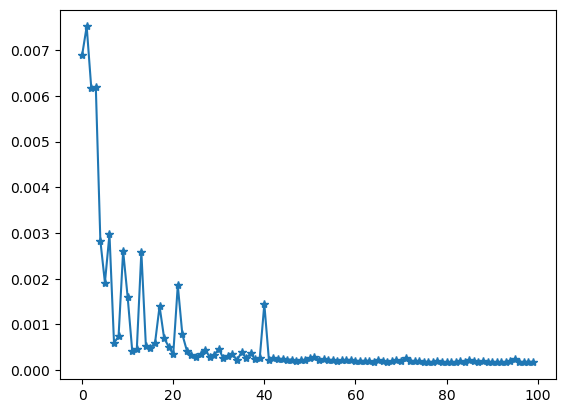

In [ ]:
# k-shot learning on unseen task wrt 40 epochs per shot
test_loss = np.zeros(100)

for i in range(100):
    sample_idx = rng.choice(len(x_test), size=i+1)
    xtest_plot = x_test[sample_idx]
    ytest_plot = y_test[sample_idx]

    optimizer = tf.keras.optimizers.Adam()

    weights_before = model.get_weights()

    # predict after 0 step
    test_loss[0] = compute_loss(x_test, y_test, model)

    # k-shot learning with N epochs
    for inneriter in range(50):
        train_on_batch(xtest_plot, ytest_plot, model, optimizer)

    test_loss[i] = compute_loss(x_test, y_test, model)
    print(test_loss[i])

    model.set_weights(weights_before)

plt.plot(test_loss, marker='*')
plt.show()